# Biodiversity Project

Let's work as a biodiversity analyst and analyse data from national parks

Note: The data for this project is *inspired* by real data, but is mostly fictional.

The questions we will try to answer:

1- are certain species more likely to be endangered?

2- How many species are endangered, threatened, in recovery, species of concern?

3- How many total sheep observations (across all species) were made at each national park?

4- How many weeks would you need to observe sheep at Bryce National Park in order to observe enough sheep?  How many weeks would you need to observe at Yellowstone National Park to observe enough sheep?

Import the modules

In [5]:
from matplotlib import pyplot as plt
import pandas as pd

There are two csv files: `species_info.csv` and `observations.csv` let's start with the `species_info.csv` data set 

# Species

In [7]:
species = pd.read_csv("species_info.csv")

In [13]:
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


Let's answer some questions.

How many different species are in the `species` DataFrame?

In [11]:
species_count= species.scientific_name.nunique()
print(species_count)

5541


What are the different values of `category` in `species`?

In [18]:
species_category = species.category.unique()
print(species_category)

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


What are the different values of `conservation_status`?

In [20]:
conserv_stats_val= species.conservation_status.unique()
print(conserv_stats_val)

[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


Let's start doing some analysis!

I'd like to count up how many species meet each of conservation status values.

In [26]:
status_counts = species.groupby('conservation_status').scientific_name.nunique().reset_index()
print(status_counts)

  conservation_status  scientific_name
0          Endangered               15
1         In Recovery                4
2  Species of Concern              151
3          Threatened               10


We saw earlier that there are around 5541 species so in the above chart, the NAN values are missing, let's add them

In [27]:
species.fillna('No Intervention', inplace=True)

In [28]:
status_counts = species.groupby('conservation_status').scientific_name.nunique().reset_index()
print(status_counts)

  conservation_status  scientific_name
0          Endangered               15
1         In Recovery                4
2     No Intervention             5363
3  Species of Concern              151
4          Threatened               10


Let's create a bar chart.  We first need to sort the columns by how many species are in each categories.

In [29]:
protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')

Now let's create a bar chart!

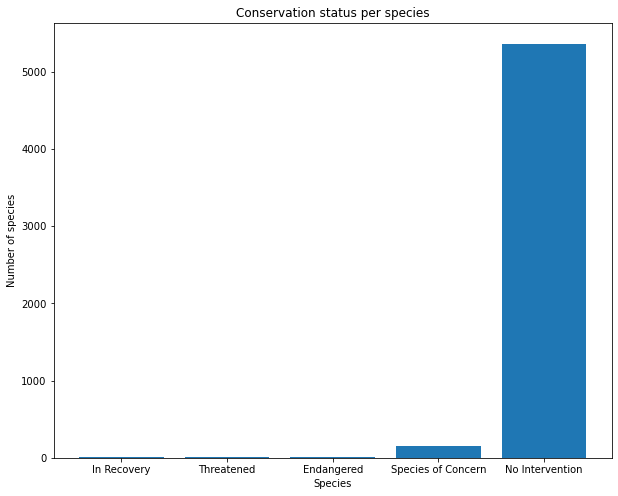

<Figure size 432x288 with 0 Axes>

In [54]:
plt.figure(figsize=(10,8))
ax=plt.subplot()
plt.bar(range(len(protection_counts)), protection_counts.scientific_name.values)
ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts.conservation_status.values)
plt.xlabel("Species")
plt.ylabel("Number of species")
plt.title("Conservation status per species")
plt.show()
plt.savefig('Conservation status per species.png')

Are certain types of species more likely to be endangered?

In [32]:
species['is_protected'] = species.conservation_status != 'No Intervention'

In [35]:
category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index()
print(category_counts)

             category  is_protected  scientific_name
0           Amphibian         False               72
1           Amphibian          True                7
2                Bird         False              413
3                Bird          True               75
4                Fish         False              115
5                Fish          True               11
6              Mammal         False              146
7              Mammal          True               30
8   Nonvascular Plant         False              328
9   Nonvascular Plant          True                5
10            Reptile         False               73
11            Reptile          True                5
12     Vascular Plant         False             4216
13     Vascular Plant          True               46


In [36]:
category_counts.head()

,category,is_protected,scientific_name
0,Amphibian,False,72
1,Amphibian,True,7
2,Bird,False,413
3,Bird,True,75
4,Fish,False,115


In [37]:
category_pivot = category_counts.pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                                .reset_index()

In [39]:
category_pivot

is_protected,category,False,True
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [40]:
category_pivot.columns = ['category', 'not_protected', 'protected']

In [42]:
category_pivot['percent_protected']= category_pivot.protected / (category_pivot.protected + category_pivot.not_protected)

In [43]:
category_pivot

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,0.088608
1,Bird,413,75,0.153689
2,Fish,115,11,0.087302
3,Mammal,146,30,0.170455
4,Nonvascular Plant,328,5,0.015015
5,Reptile,73,5,0.064103
6,Vascular Plant,4216,46,0.010793


It looks like species in category `Mammal` are more likely to be endangered than species in `Bird`.  We're going to do a significance test to see if this statement is true. Since it is a categorical data and we'll compare two samples, we need to do a chi squared test.

In [44]:
from scipy.stats import chi2_contingency
contingency = [[30, 146],
              [75, 413]]

In [45]:
chi2_contingency(contingency)

(0.1617014831654557,
 0.6875948096661336,
 1,
 array([[ 27.8313253, 148.1686747],
        [ 77.1686747, 410.8313253]]))

It looks like this difference isn't significant!

Let's test another.  Is the difference between `Reptile` and `Mammal` significant?

In [46]:
contingency = [[30, 146],
               [5, 73]]
chi2_contingency(contingency)

(4.289183096203645,
 0.03835559022969898,
 1,
 array([[ 24.2519685, 151.7480315],
        [ 10.7480315,  67.2519685]]))

Yes! It looks like there is a significant difference between `Reptile` and `Mammal`!

# Observations

In [47]:
observations = pd.read_csv("observations.csv")
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


Some scientists are studying the number of sheep sightings at different national parks.  There are several different scientific names for different types of sheep.  We'd like to know which rows of `species` are referring to sheep. 

In [50]:
species['is_sheep']= species.common_names.apply(
lambda x: True if 'Sheep' in x else False
)

In [51]:
species[species.is_sheep]

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
1139,Vascular Plant,Rumex acetosella,"Sheep Sorrel, Sheep Sorrell",No Intervention,False,True
2233,Vascular Plant,Festuca filiformis,Fineleaf Sheep Fescue,No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3758,Vascular Plant,Rumex acetosella,"Common Sheep Sorrel, Field Sorrel, Red Sorrel,...",No Intervention,False,True
3761,Vascular Plant,Rumex paucifolius,"Alpine Sheep Sorrel, Fewleaved Dock, Meadow Dock",No Intervention,False,True
4091,Vascular Plant,Carex illota,"Sheep Sedge, Smallhead Sedge",No Intervention,False,True
4383,Vascular Plant,Potentilla ovina var. ovina,Sheep Cinquefoil,No Intervention,False,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


Many of the results are actually plants.  We'll select the rows of `species` where `is_sheep` is `True` and `category` is `Mammal`.

In [53]:
sheep_species = species[(species.is_sheep == True) & (species.category == 'Mammal')]
sheep_species

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


Now we'll merge `sheep_species` with `observations` to get a DataFrame with observations of sheep.

In [55]:
sheep_observations = observations.merge(sheep_species)
sheep_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_sheep
0,Ovis canadensis,Yellowstone National Park,219,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
1,Ovis canadensis,Bryce National Park,109,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
2,Ovis canadensis,Yosemite National Park,117,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3,Ovis canadensis,Great Smoky Mountains National Park,48,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4,Ovis canadensis sierrae,Yellowstone National Park,67,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
5,Ovis canadensis sierrae,Yosemite National Park,39,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
6,Ovis canadensis sierrae,Bryce National Park,22,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
7,Ovis canadensis sierrae,Great Smoky Mountains National Park,25,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
8,Ovis aries,Yosemite National Park,126,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
9,Ovis aries,Great Smoky Mountains National Park,76,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True


How many total sheep observations (across all three species) were made at each national park?

This is the total number of sheep observed in each park over the past 7 days.

In [56]:
obs_by_park = sheep_observations.groupby('park_name').observations.sum().reset_index()
obs_by_park

,park_name,observations
0,Bryce National Park,250
1,Great Smoky Mountains National Park,149
2,Yellowstone National Park,507
3,Yosemite National Park,282


Bar chart time

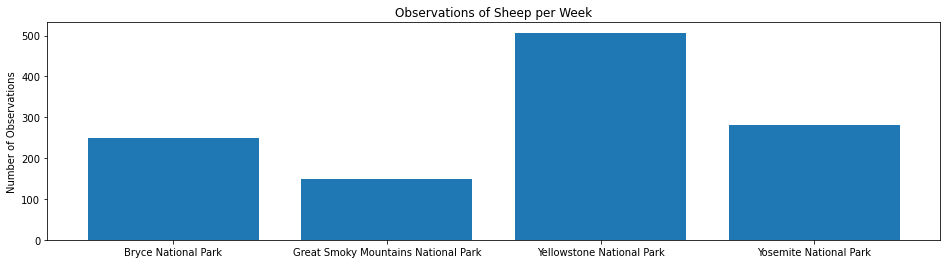

<Figure size 432x288 with 0 Axes>

In [58]:
plt.figure(figsize=(16, 4))
ax = plt.subplot()
plt.bar(range(len(obs_by_park)),
        obs_by_park.observations.values)
ax.set_xticks(range(len(obs_by_park)))
ax.set_xticklabels(obs_by_park.park_name.values)
plt.ylabel('Number of Observations')
plt.title('Observations of Sheep per Week')
plt.show()
plt.savefig('Observations of sheep per week.png')

The scientists know that 15% of sheep at Bryce National Park have foot and mouth disease.  Park rangers at Yellowstone National Park have been running a program to reduce the rate of foot and mouth disease at that park.  The scientists want to test whether or not this program is working.  They want to be able to detect reductions of at least 5 percentage points.  For instance, if 10% of sheep in Yellowstone have foot and mouth disease, they'd like to be able to know this, with confidence.

Using a sample size calculator, we want to calculate the number of sheep that they would need to observe from each park.  We'll use the default level of significance (90%).

First we need to calculate the minimum detectable effect

In [59]:
minimum_detectable_effect = 100 * 0.05 / 0.15
minimum_detectable_effect

33.333333333333336

In [60]:
baseline = 15

In [61]:
sample_size_per_variant = 870

How many weeks would you need to observe sheep at Bryce National Park in order to observe enough sheep?  How many weeks would you need to observe at Yellowstone National Park to observe enough sheep?

In [62]:
bryce = 870 / 250.
yellowstone = 870 / 507.

# Approximately 3.5 weeks at Bryce and 1.7 weeks at Yellowstone.